In [7]:
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.colors as mcolors
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from pykrige.ok import OrdinaryKriging
# import pykrige.kriging_tools as kt
# from pykrige.kriging_tools import write_asc_grid
# import gstools as gs

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import gstools as gs
from matplotlib import cm

import sys
sys.path.append('../')
from utils import tree

In [8]:
data_file = "../../../../data/one_day_data/2020/08/2020-08-01"
print(os.path.exists(data_file))
df = pd.read_csv(data_file + '/4-30.csv', index_col=0)
df.head()

True


,LON,LAT,hour-rain,AT1,RH1,SOL,WD1,WS1,PRS,SLP
Vlz-Bagbaguin_00174731,121.0009,14.7134,0.0,28.200000,53.200000,27.000000,226.000000,2.000000,1007.600000,1010.500000
NagNayon_00181273,121.0285,14.7192,0.0,29.400000,54.600000,54.000000,173.000000,0.600000,1004.800000,1011.100000
Sinegue_00181300,120.9319,14.4599,39.0,24.800000,81.500000,41.000000,89.000000,0.200000,1008.900000,1010.600000
DLSAU_00174722,120.9974,14.6705,0.0,26.532066,73.482975,178.104132,148.930579,0.326116,1008.667273,1011.166942
ASTI_00173457,121.0721,14.6471,0.0,28.600000,51.400000,219.000000,320.000000,3.200000,1002.800000,1010.500000


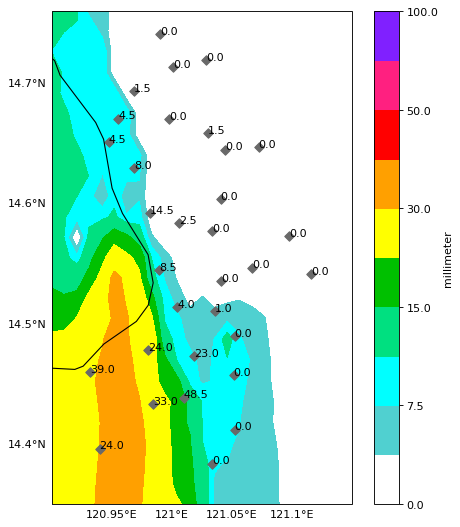

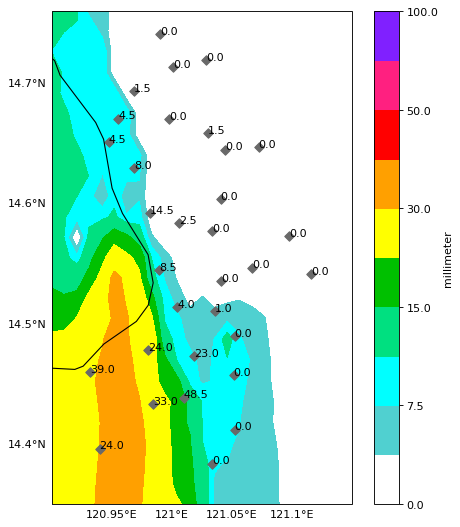

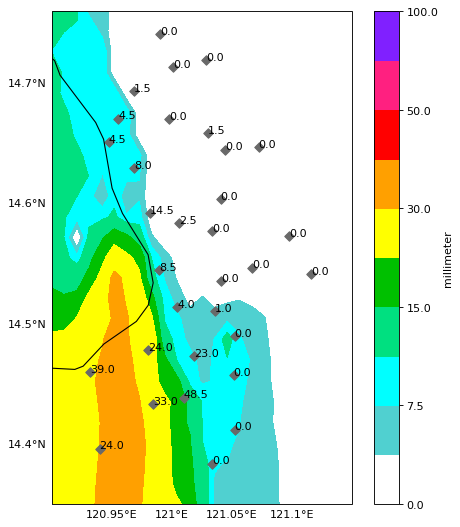

In [11]:
def show_img(method, num_cols=25):
#     print('-'*30, kernel, '-'*30)
#     print('epslilon:', epsilon, ' neighbors:', neighbors)
    idw_tree = tree(df[['LON', 'LAT']], df['hour-rain'])

    grid_lon = np.round(np.linspace(120.90, 121.150, num_cols), decimals=3)
    grid_lat = np.round(np.linspace(14.350, 14.760, num_cols), decimals=3)
    x2 = np.meshgrid(grid_lon, grid_lat)
    
    grid_shape = x2[0].shape
    x2 = np.reshape(x2, (2, -1)).T
    z1 = idw_tree(x2)
#     grid_lon = np.round(np.linspace(120.90, 121.150, num_cols), decimals=3)
#     grid_lat = np.round(np.linspace(14.350, 14.760, num_cols), decimals=3)
#     xi, yi = np.meshgrid(grid_lon, grid_lat)
#     f = griddata(df[['LON', 'LAT']], df['hour-rain'], (xi, yi), method=method)
#     grid_lon = np.round(np.linspace(120.90, 121.150, 50), decimals=3)
#     grid_lat = np.round(np.linspace(14.350, 14.760, 50), decimals=3)
#     xi, yi = np.meshgrid(grid_lon, grid_lat)
    xgrid = np.around(np.mgrid[120.90:121.150:25j, 14.350:14.760:25j], decimals=3)
    xfloat = np.around(xgrid, decimals=3).reshape(2, -1).T
    
    xmi, ymi = xfloat[:, 0], xfloat[:, 1]
#     print(xmi)
#     print('-'*50)
#     print(xi)
#     print('-'*50)
#     print(xfloat)
    
#     z1 = f(grid_lon, grid_lat)
    z1 = z1.T
    z1 = z1.reshape(num_cols, num_cols)
    rain_data = np.where(z1 > 100, 100, z1)
    rain_data = np.where(rain_data < 0, 0, rain_data)
    
    fig = plt.figure(figsize=(7, 8), dpi=80)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([120.90, 121.150, 14.350, 14.760])
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, alpha=0)
    gl.right_labels = False
    gl.top_labels = False
    
    clevs = [0, 5, 7.5, 10, 15, 20, 30, 40, 50, 70, 100]
    cmap_data = [(1.0, 1.0, 1.0),
                (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                (0.0, 1.0, 1.0),
                (0.0, 0.8784313797950745, 0.501960813999176),
                (0.0, 0.7529411911964417, 0.0),
                (0.501960813999176, 0.8784313797950745, 0.0),
                (1.0, 1.0, 0.0),
                (1.0, 0.6274510025978088, 0.0),
                (1.0, 0.0, 0.0),
                (1.0, 0.125490203499794, 0.501960813999176),
                (0.9411764740943909, 0.250980406999588, 1.0),
                (0.501960813999176, 0.125490203499794, 1.0),
                ]
    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)

    cs = ax.contourf(*xgrid, rain_data, clevs, cmap=cmap, norm=norm)
    
    cbar = plt.colorbar(cs, orientation='vertical')
    cbar.set_label('millimeter')
    ax.scatter(df['LON'], df['LAT'], marker='D', color='dimgrey')
    for i, val in enumerate(df['hour-rain']):
        ax.annotate(val, (df['LON'][i], df['LAT'][i]))
    plt.show()
    plt.close()

    
for method in ['linear', 'nearest', 'cubic']:
    show_img(method)